# Support Vector Machines

At this point in the semester, you have learned about support vector machines and kernels and how they are used to find linear and nonlinear decision boundaries for binary classification. In completing this notebook you will become more familiar with some important concepts in machine learning:

- __Mathematical optimization__
    - Review Lagrange multipliers and constrained optimization
- __Kernel methods__
    - Experiment with polynomial and RBF kernels to perform nonlinear classification
    - Observe example scenarios in which linear kernels fail
    - Choose the right kernel for different problems
- __Hyperparameter tuning__
    - Automate the selection of SVM regularization hyperparameter on a held-out dataset
- __Interpreting weights and support vectors__
    - Train a linear SVM for digit detection
    - Interpret weights and support vectors

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import numpy as np
import util
import runClassifier
import datasets
import matplotlib.pyplot as plt
import sklearn

import lagrangian
import svm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Lagrange multipliers and constrained optimization

As you have learned in the lecture on SVMs, Lagrangians help to convert constrained optimization problems to unconstrained ones, which is useful for finding optimal-margin classifiers. Here we will visualize an example of this technique in action.

Let's start with an abstract example. Suppose we have the following constrained optimization problem


\begin{equation*}
\begin{aligned}
& \underset{x}{\text{minimize}}
& & x^2+10 \\
& \text{subject to}
& & x \geq 3
\end{aligned}
\end{equation*}


represented by the following figure.

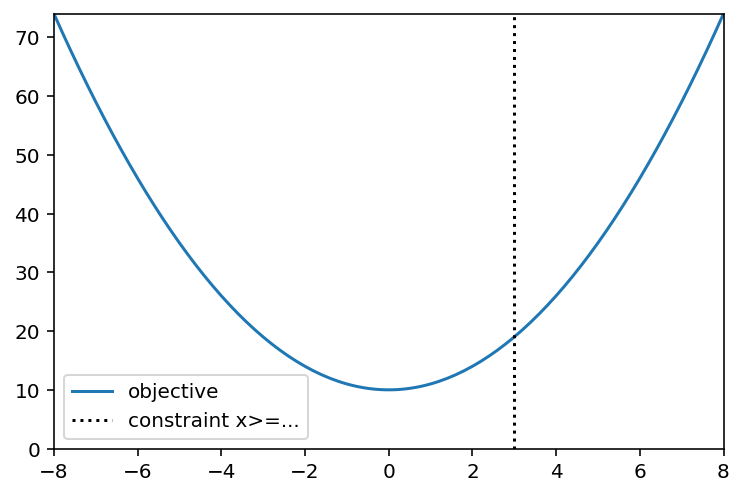

In [7]:
%matplotlib inline
lagrangian.makePlot('objective')

Applying the Lagrangian method, we'll create a Lagrangian function that we can minimize without constraints. Let's plot the Lagrangian. The plot is 3D, so you can spin it around. You might need to run the cell a few times to get the graphics to show.

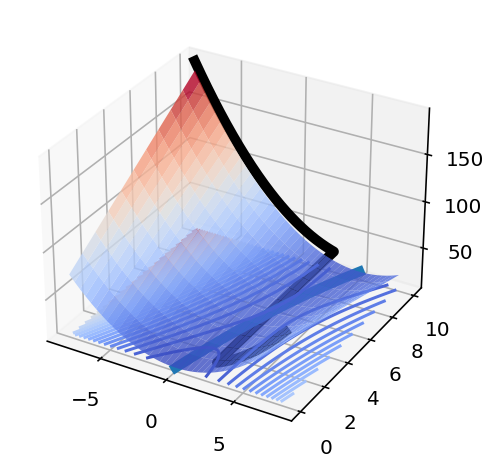

In [14]:
# %matplotlib notebook
%matplotlib inline
lagrangian.makePlot('lagrangian')

The Lagrangian is the surface you see with colors ranging from cool to warm. The axis ranging from -8 to +8 is $x$. The axis ranging from 0 to 10 is $\alpha$. Now, we can maximize this function over $\alpha$ and minimize over $x$. The black line shows the optimal (maximal) value of $\alpha$ for any given $x$. The blue line shows the optimal (minimal) value of $x$ for any given $\alpha$. We can also see this with a contour plot.

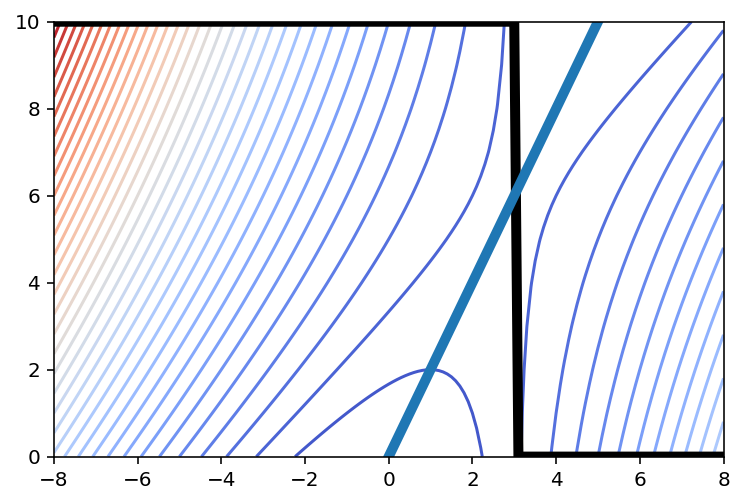

In [12]:
%matplotlib inline
lagrangian.makePlot('contour')

Let's show the optimization problem just as a function of $\alpha$. That is, for any given value of $\alpha$, we find the value of the Lagrangian if we fix $\alpha$ and maximize over $x$.

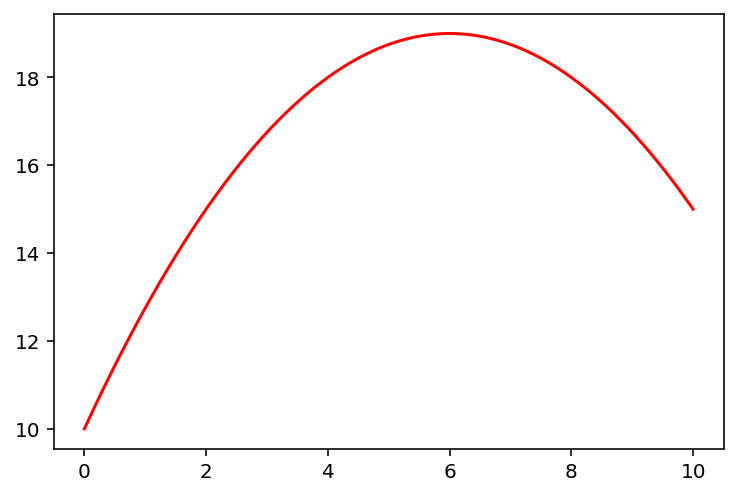

In [15]:
%matplotlib inline
lagrangian.makePlot('alpha')

Let's check that this makes sense. We will look at the Lagrangian again.

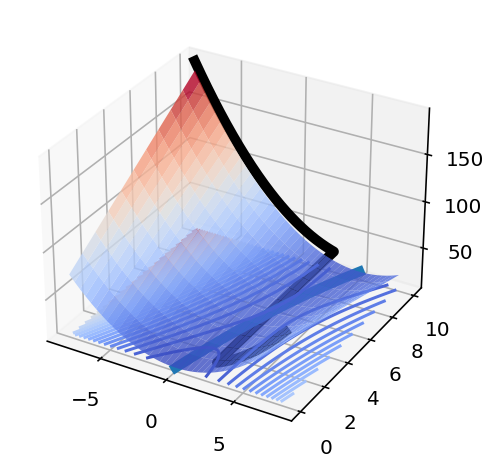

In [17]:
%matplotlib notebook
%matplotlib inline
lagrangian.makePlot('lagrangian')

__QUESTION 1:__ Spin the 3D figure around so that you're looking at it from the perspective of $x$ (so you see -8..8 on the x-axis and the 0..10 axis is going "away" from you). You should be able to see a saddle point in the black curve where it hits a minimum. For what value of $x$ does it attain that minimum? Is this consistent with Figure 4 above (the optimization problem as function of $\alpha$)?

__ANSWER 1:__ x=3. It is consistent with the saddle point in Figure 4.

Suppose we change the constraint to $x \geq -2$, instead of the current $x \geq 3$. Let's make all the plots for this new problem.

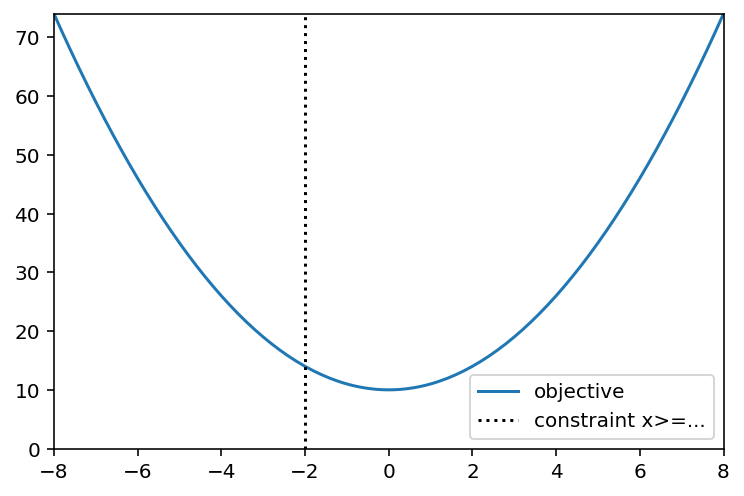

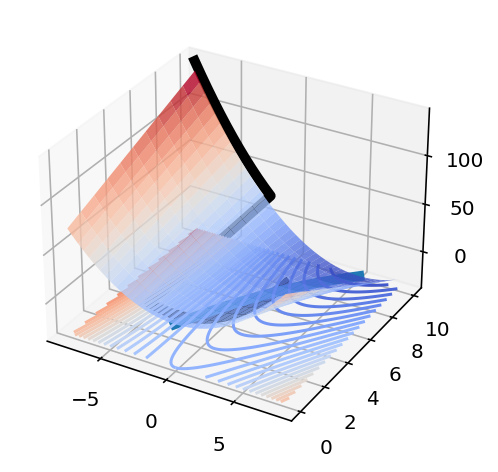

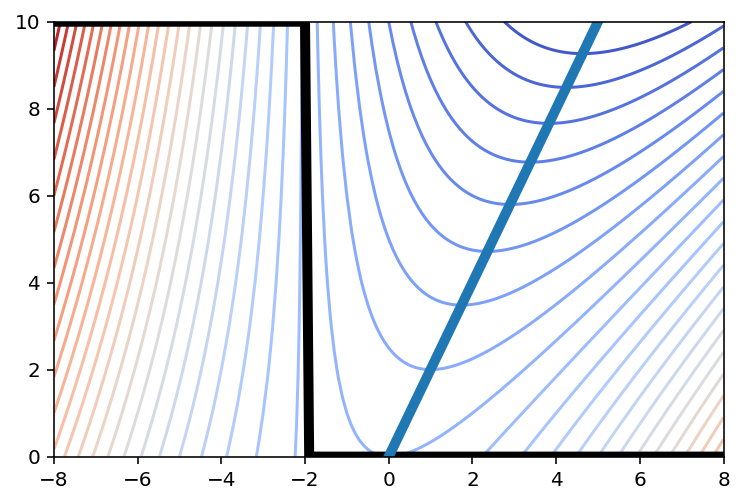

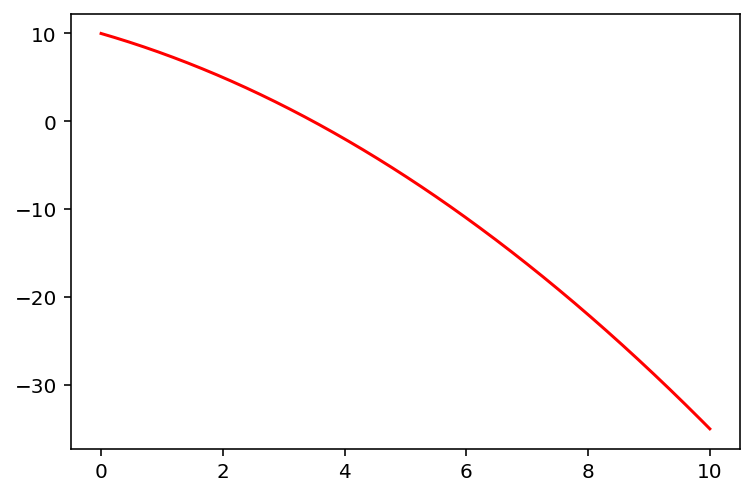

In [18]:
%matplotlib inline
lagrangian.makePlot('all', constraint_x_ge=-2)

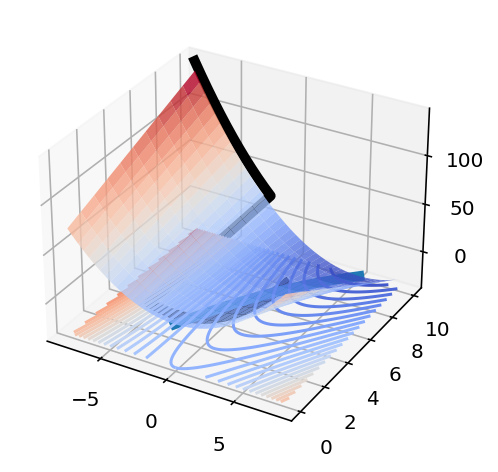

In [20]:
%matplotlib notebook
%matplotlib inline
lagrangian.makePlot('lagrangian', constraint_x_ge=-2)

__QUESTION 2:__ Repeat question 1, but for this new figure.

__ANSWER 2:__ x=0. It is consistent with Figure 4.

__QUESTION 3:__ Look at the new Figure 4 (the optimization problem as a function of $\alpha$). Where is the optimum for $\alpha$? What does this tell you about the constraint in the constrained optimization?

__ANSWER 3:__ The optimum for $\alpha$ is 0, which means that the constrain does not affect the minimum of the objective, i.e., the local minimum is the global minimum,
which is clear in the Figure 1.

## Linear kernel

Now we will experiment with different kernels by applying the SVM to several classification problems. We will use `sklearn.svm`, which is a wrapper around LIBSVM. We will start by training a simple SVM with a linear kernel and regularization parameter C=100. The SVM will be trained on `Data0`, and we will save our model to `models/data0.model`.

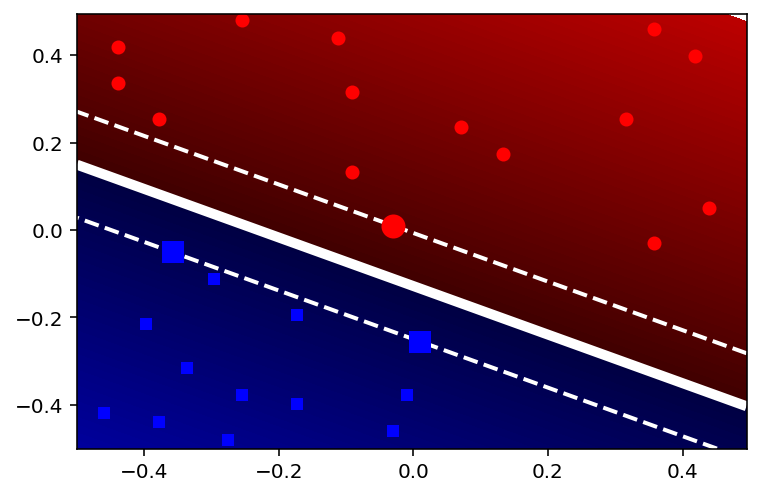

In [22]:
%matplotlib inline
data = datasets.Data0
svm.train(data.X, data.Y,'models/data0.model',k='linear',c=100)
svm.drawBoundary(data.X, data.Y,'models/data0.model')

This is an easily separable dataset, which is reflected by the small number of support vectors. In the plot, the SVs are drawn big (and are on the margin, the dashed line one unit away from the decision boundary, the solid line).

__QUESTION 4:__ You should have found that it takes 3 support vectors. Could you have fewer (eg., 2) support vectors here?

__ANSWER 4:__  We cannot find fewer because SVM is guaranteed to converge to the global optimum in this linearly separable case, i.e., its solution is unique.
Hard margin SVM is a convex optimization problems.
However, for soft margin SVM with regularization,
I am not sure whether it can always converge to the global optimum.

## Polynomial kernel

Although it is unnecessary, suppose we wanted to use the polynomial kernel $K(x,z)=(1+x\cdot z)^{10}$. Then we would run

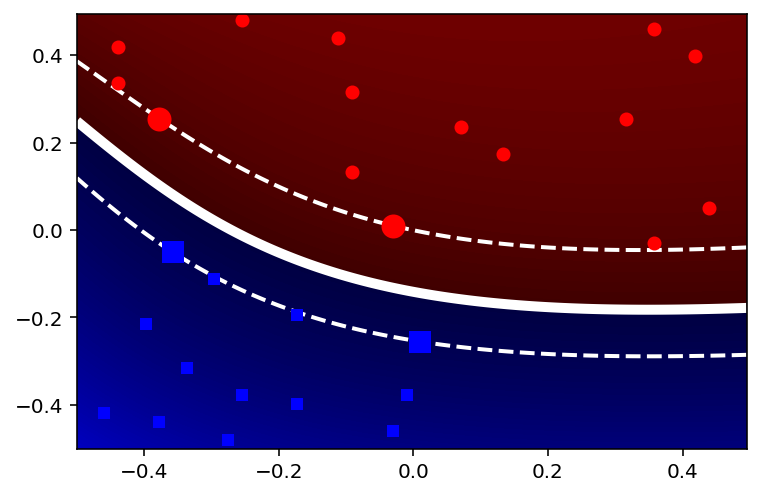

In [23]:
data = datasets.Data0
svm.train(data.X, data.Y,'models/data0.model',k='poly',c=100,r=1,d=10)
svm.drawBoundary(data.X, data.Y,'models/data0.model')

You'll see that you get a curved decision boundary, though of course this is somewhat overkill.

## RBF kernel

Let's try the RBF kernel with $\gamma =1$.

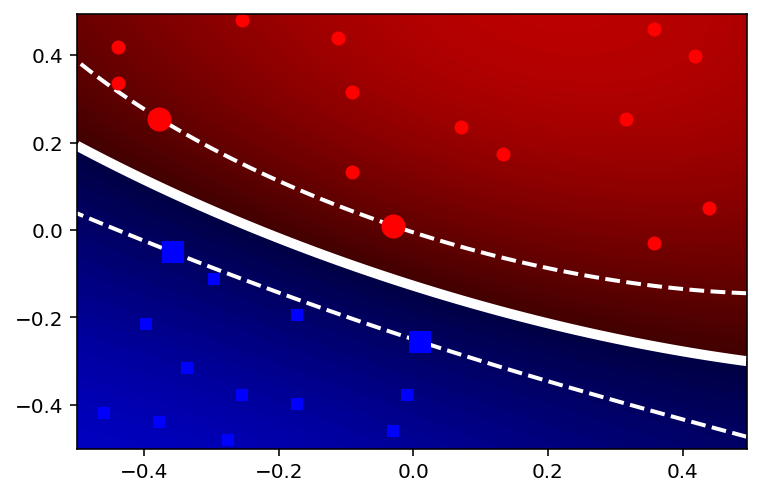

In [24]:
data = datasets.Data0
svm.train(data.X, data.Y,'models/data0.model',k='rbf',c=100,g=1)
svm.drawBoundary(data.X, data.Y,'models/data0.model')

Again, this is overkill. But we can try to understand RBF kernels a bit better by "turning up" the gamma:

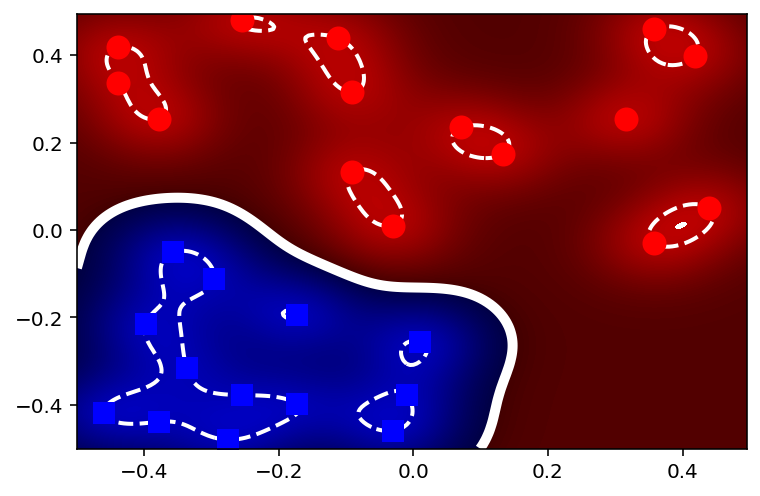

In [25]:
data = datasets.Data0
svm.train(data.X, data.Y,'models/data0.model',k='rbf',c=100,g=100)
svm.drawBoundary(data.X, data.Y,'models/data0.model')

A gamma of 100 means that you have to be really close to a point to have a kernel value that's non-zero.

__QUESTION 5:__ Why do you get these little blobs?

__ANSWER 5:__ The C parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
For larger values of C, a smaller margin will be accepted if the decision function is better at classifying all training points correctly. 
A lower C will encourage a larger margin, therefore a simpler decision function, at the cost of training accuracy.
In the above case, the gamma is so large that the SVM is overfitting.
These little blobs mean all points are support vectors,
i.e., all points have the same distance to the decision boundary (hyperplane) in the high-dimensional feature space.
The reason is that the RBF kernel function is always close to 0 
\begin{equation}\label{eq:rbf}
    K(x,x')
    =
    \exp (-\gamma ||x-x'||^2)
    \approx 
    0
\end{equation}
when $\gamma$ is very large. 

__TASK 1:__ How high do you have to turn gamma up in order to get a little decision boundary around each example? Set gamma below.

/Users/jue/GitHub/Quantum-Diffusion-Kernel/misc/SVM/svm.py:145: UserWarning: No contour levels were found within the data range.
  contour(X0, Y0, Z, levels=[-1], linewidths=[2], colors='w', linestyles='dashed')
/Users/jue/GitHub/Quantum-Diffusion-Kernel/misc/SVM/svm.py:146: UserWarning: No contour levels were found within the data range.
  contour(X0, Y0, Z, levels=[1], linewidths=[2], colors='w', linestyles='dashed')


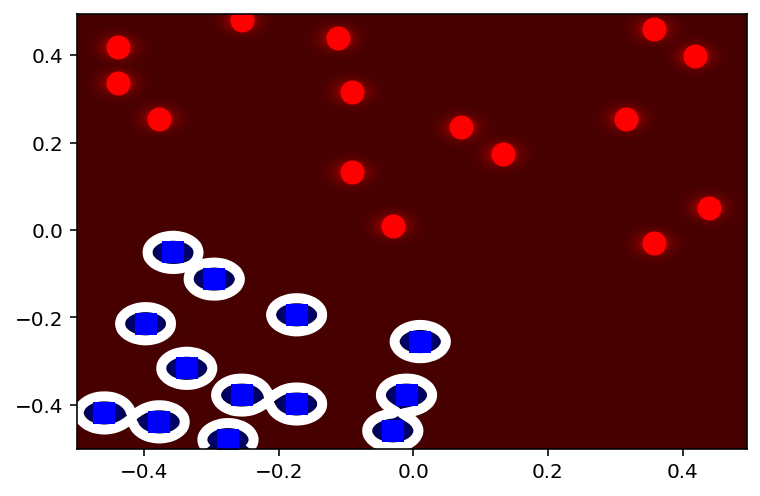

In [26]:
data = datasets.Data0
svm.train(data.X, data.Y,'models/data0.model',k='rbf',c=100,g=1900)
svm.drawBoundary(data.X, data.Y,'models/data0.model')

## Choosing the right kernel

Let's now switch to a more complex dataset to see why choosing the right kernel matters. We'll begin by failing with a linear model:

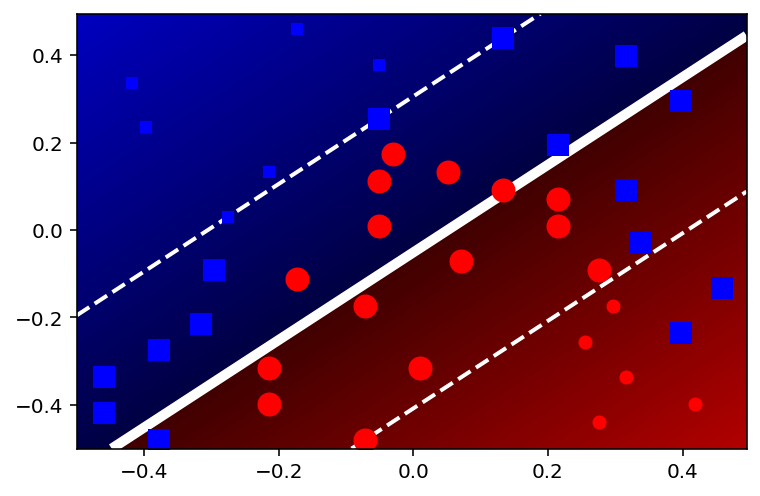

In [27]:
data = datasets.Data1
svm.train(data.X, data.Y,'models/data1.model',k='linear',c=100)
svm.drawBoundary(data.X, data.Y,'models/data1.model')

As you can see, this data fails horribly.

__QUESTION 6:__ There are a lot of red support vectors on the blue side of the decision boundary. Why?

__ANSWER 6:__ This dataset is not linearly separable.

However, now we can get some mileage out of polynomial kernels:

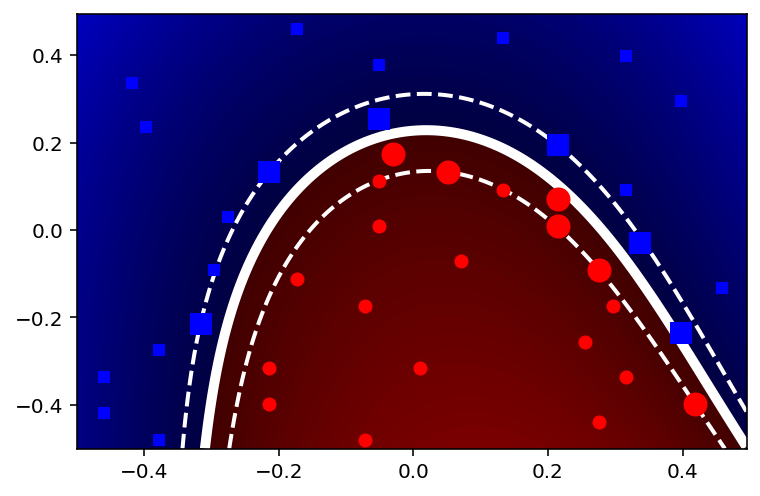

In [28]:
data = datasets.Data1
svm.train(data.X, data.Y,'models/data1.model',k='poly',c=100,r=1,d=3)
svm.drawBoundary(data.X, data.Y,'models/data1.model')

__QUESTION 7:__ Based on this data, is the 0/1 loss on the training data zero? Is the hinge loss on the training data zero?

__ANSWER 7:__ 0/1 loss is zero, but hinge loss is not zero.

__TASK 2:__ Train an SVM with RBF kernel on this data. What's the smallest gamma for which you can get a good decision boundary?

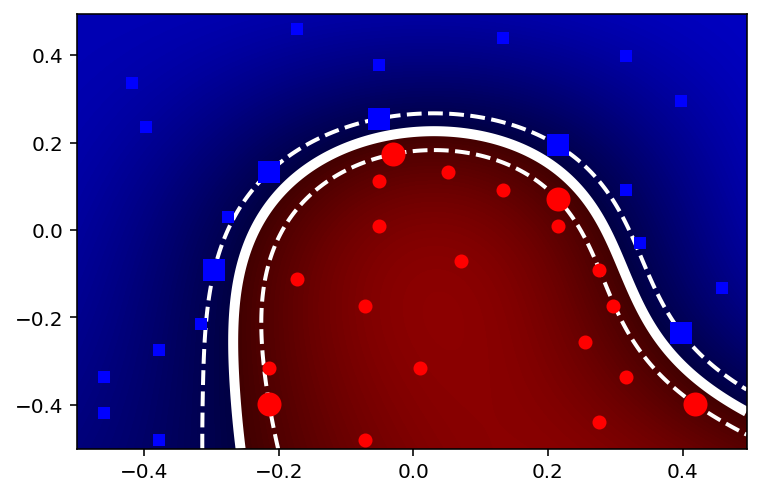

In [29]:
# your code here
data = datasets.Data1
svm.train(data.X, data.Y,'models/data0.model',k='rbf',c=100,g=3)
svm.drawBoundary(data.X, data.Y,'models/data0.model')

## SVM regularization parameter

Let's train an SVM on a simple 2-dimensional binary classification task. Our dataset is `BinaryWithOutliers`, and we will save our model to `models/bwo.model`. Experiment with different values of the `C` regularization hyperparameter below.

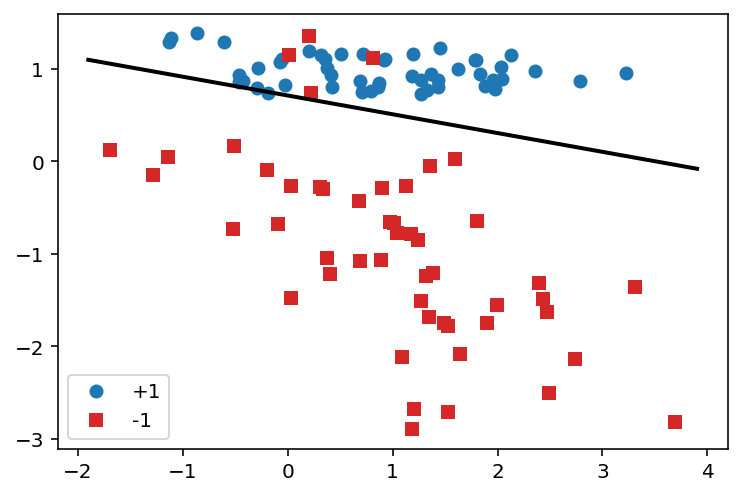

In [30]:
# Overfitting example
%matplotlib inline
data = datasets.BinaryWithOutliers
f = svm.train(data.X, data.Y,'models/bwo.model',k='linear',c=10000000000)
runClassifier.plotDataAndBoundary(data.X,data.Y,f.coef_[0],f.intercept_[0])

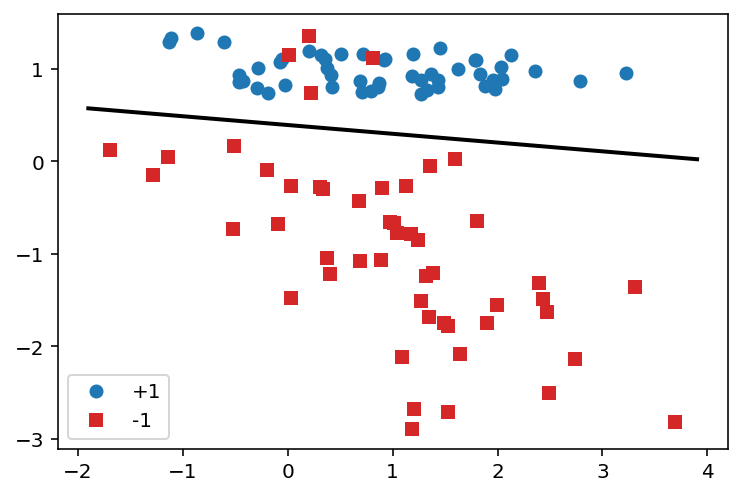

In [31]:
# the example with proper parameter
%matplotlib inline
data = datasets.BinaryWithOutliers
f = svm.train(data.X, data.Y,'models/bwo.model',k='linear',c=1)
runClassifier.plotDataAndBoundary(data.X,data.Y,f.coef_[0],f.intercept_[0])

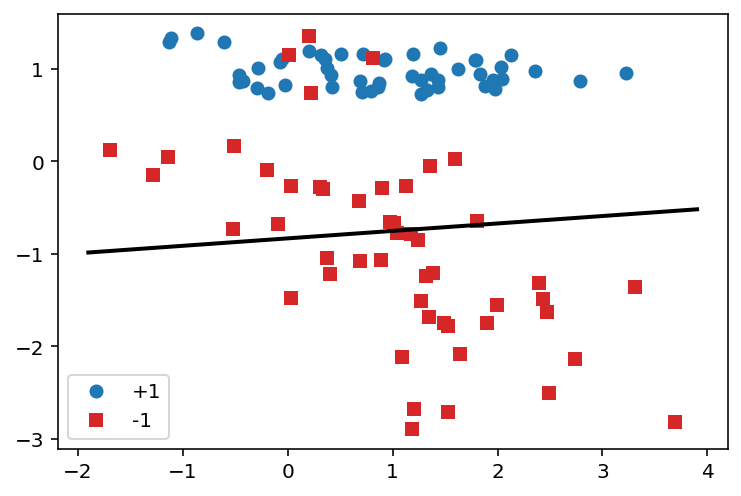

In [32]:
# underfitting example
%matplotlib inline
data = datasets.BinaryWithOutliers
f = svm.train(data.X, data.Y,'models/bwo.model',k='linear',c=0.000001)
runClassifier.plotDataAndBoundary(data.X,data.Y,f.coef_[0],f.intercept_[0])

__QUESTION 8:__ Which values of `C` lead to underfitting? Which values lead to overfitting? Why?

__ANSWER 8:__ The `C` parameter trades off correct classification of training examples against maximization of the decision function’s margin. 
For larger values of `C`, a smaller margin will be accepted if the decision function is better at classifying all training points correctly, i.e., leads to overfitting. 
A lower `C` will encourage a larger margin, therefore a simpler decision function, 
at the cost of training accuracy, i.e., leads to underfitting. 

This establishes the basic idea of why it is important to tune the regularization parameter. Let's move on to the sentiment prediction task. We want to train a linear SVM on `SentimentData`, and choose the best value for `C`. We will estimate underfitting and overfitting on a held-out subset of the training data. We will use an 80/20 train/validation split of the first 400 examples in `SentimentData`, because training the SVM on the full dataset takes some time. In the real world, you will want to use as much data as possible.

In [33]:
data = datasets.SentimentData
t = 320
v = 80
trainX,trainY = data.X[0:t],data.Y[0:t]
valX,valY = data.X[t:t+v],data.Y[t:t+v]

__TASK 3:__ Given `trainX`,`trainY`,`valX`,`valY`, write code below to automate the process of choosing a good value for `C`. You must store your best `C` in `bestC`. To compute the score of a trained model `f` on inputs in `X` and corresponding labels in `Y`, write `f.score(X,Y)`.

Make sure you search a broad range of values in the feasible region (C>0). 
Compare C=1e-5 with C=1e5 for question 8. 
You should notice a significant difference in the position of the decision boundary. 
Same idea applies to Task 3.
A reasonable approach is to try a sequence of exponentially increasing values of C.

In [34]:
bestC = 0 # you must store your best C in this variable
# your code here
f = svm.train(trainX, trainY,'models/bwo.model',k='linear',c=1)

1e-05
0.0001
0.001
0.01
0.1
1.0
10.0
100.0
1000.0
10000.0
100000.0


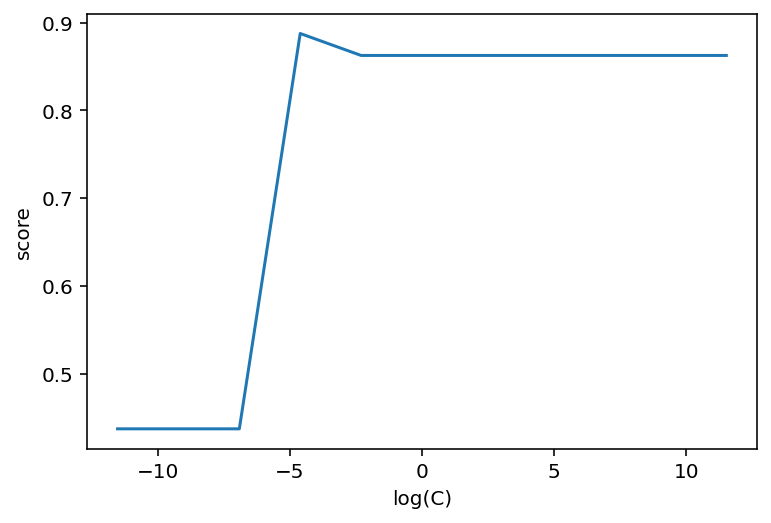

In [35]:
c = np.array([0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000])
score = []
for i in c:
    print(i)
    f = svm.train(trainX, trainY,'models/bwo.model',k='linear',c=i)
    temp = f.score(valX, valY)
    score.append(temp)
    
plt.plot(np.log(c), score)
plt.xlabel('log(C)')
plt.ylabel('score')
plt.show()

In [36]:
bestC = c[np.argmax(score)]
bestC # run this cell so that we can see it

0.01

## SVM for digit detection

We will train a support vector machine to classify digits as 1 or 2, with a dataset of 100 grayscale images of resolution 28x28. The images have been reshaped to 784 for training.

In [37]:
data = datasets.DigitData
f = svm.train(data.X, data.Y,'models/digit.model',k='linear',c=100, prob=True)

It should train very quickly, as the dataset is rather small. Let's get the weight vector and the support vectors. There should be about 28 support vectors.

In [38]:
w = f.coef_
svs = f.support_vectors_

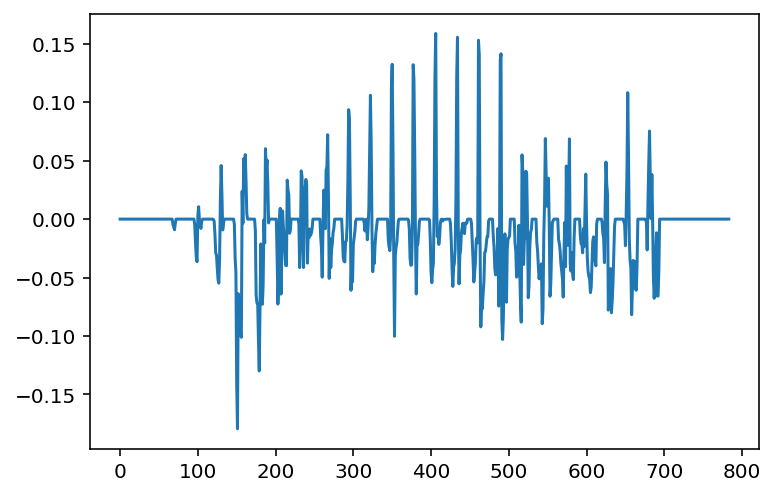

In [39]:
plt.plot(w.flatten())

__TASK 4:__ Write a method `show_wimg` that takes in a weight vector of length 784, converts it to a 28x28 image with color intensity values (0 to 255), and displays it with `plt.imshow`. We will use it to display the weight vector and support vectors.

In [40]:
def show_wimg(X):
    img = X.copy()
    max_value = np.amax(X)
    min_value = np.amin(X)
    for i in range(len(X)):
        img[i] = 255 * (X[i] - min_value) / (max_value - min_value)
#     plt.plot(img.flatten())
#     print(img)
        
    img = img.reshape(28,28)
    plt.imshow(img)

Now we can visualize the weight vector.

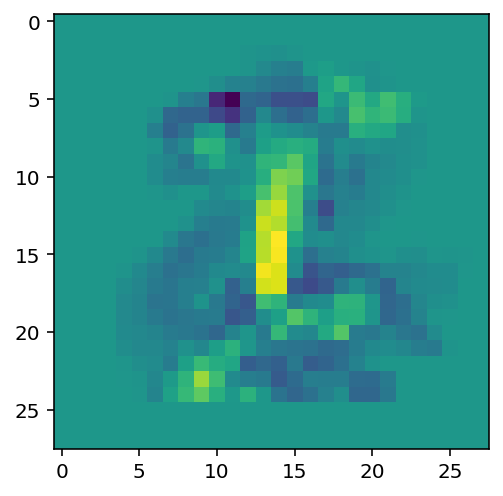

In [41]:
show_wimg(w)
plt.show()

__QUESTION 9:__ Inspect the image of the weight vector. What does this weight vector tell you about how it classifies images as either 1 or 2?

__ANSWER 9:__ The larger intensity/weights (black) tend to classifying images as digit `2` and
the smaller ones tend to classifying images as digit `1`.

Change the index in the code below to display some support vectors. Try to understand what these support vectors suggest about the classifier. See if you can find anything unique about them.

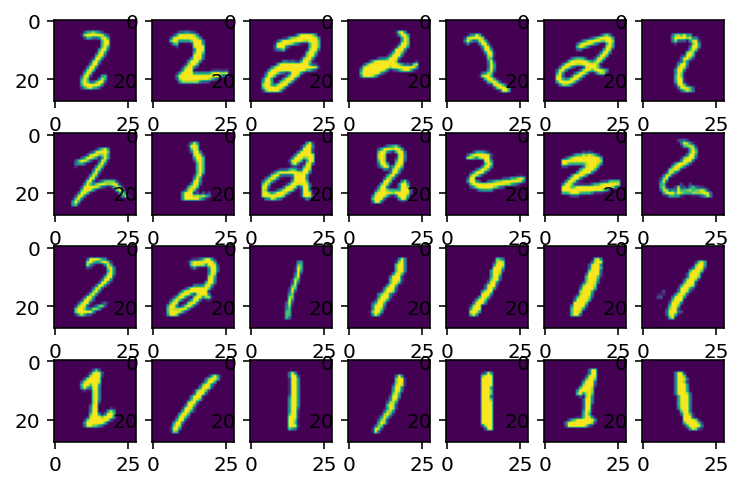

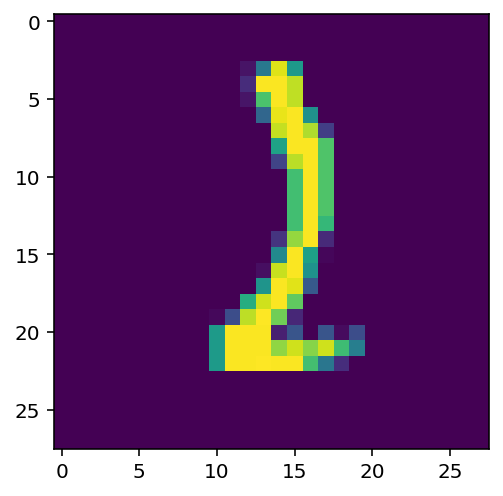

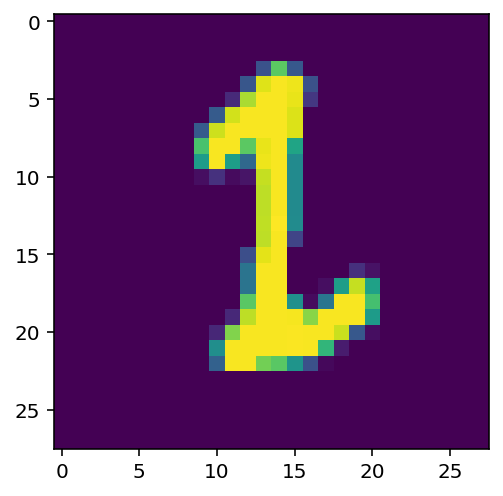

In [42]:
for i in range(28):
    plt.subplot(4, 7, i+1)
    show_wimg(svs[i])
    
plt.show()
show_wimg(svs[8])
plt.show()
show_wimg(svs[21])
plt.show()

__QUESTION 10:__ What did you find? Based on your understanding of how support vectors are used to find an optimal-margin decision boundary, what do the nature of the support vectors, and how many there are, suggest about this SVM's ability to generalize?

__ANSWER 10:__ We can find 16 support vectors for digit `2` and 12 support vectors for digit `1` .
The support vectors are the figures which are the most difficult to be classified as either `1` or `2`.
In other words, these digit `1` and `2` share some similar traits.
For example, the 9th support vector(`2`) and the 22nd support vector(`1`) are very similar.
A large number of support vectors mean there are many similar digits,
i.e., this SVM is poor to generalize. 
If the number of support vectors is small, it is good to generalize 
because most of them are distinct.

## Learn more

### LIBSVM
- [LIBSVM -- A Library for Support Vector Machines](https://www.csie.ntu.edu.tw/~cjlin/libsvm/)
- [1.4. Support Vector Machines — scikit-learn 0.20.0 documentation](https://scikit-learn.org/stable/modules/svm.html)